In [0]:
import random as rand
import warnings

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]
import pylab as pl
from IPython import display

from datetime import datetime, timedelta
import time
import random as rand
warnings.filterwarnings('ignore')


In [0]:
url = "https://raw.githubusercontent.com/nicholausdy/COVID19_Simulation/master/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url).drop(labels=['Lat','Long'],axis=1)
df = pd.melt(df, id_vars=['Province/State','Country/Region'], var_name='date', value_name='cases')
df['date'] = df['date'].astype('datetime64')

total = df.groupby('date').sum().reset_index()

In [0]:
POP = 1000000     # assume population 1 mil
CONTACT = 4              # people in contact per day
INFECT_CHANCE = 0.054    # chance of being infected when close to person in radius
FLIGHTS = 34.2/264/365   # flights per day
ASYM = 0.505             # % of being asymptomatic while infected

# flights source = https://centreforaviation.com/analysis/reports/indonesia-international-aviation-rapid-growth-and-strong-competition-410927

In [0]:
 age = ['0-19', '20-44', '45-54', '55-64', '65-74', '75-84', '85'] 

hosl = [1.6, 14.3, 21.2, 20.5, 28.6, 30.5, 31.3]
hosu = [2.5, 20.8, 28.3, 30.1, 43.5, 58.7, 70.3]

icul = [0, 2, 5.4, 4.7, 8.1, 10.5, 6.3];   icul = [a*100/b for a,b in zip(icul,hosl)]
icuu = [0, 4.2, 10.4, 11.2, 18.8, 31, 29]; icuu = [a*100/b for a,b in zip(icuu,hosu)]

fatl = [0, 0.1, 0.5, 1.4, 2.7, 4.3, 10.4];  #fatl = [0 if b==0 else a*100/b for a,b in zip(fatl,icul)]
fatu = [0, 0.2, 0.8, 2.6, 4.9, 10.5, 27.3]; #fatu = [0 if b==0 else a*100/b for a,b in zip(fatu,icuu)]

indo = [433, 521, 169, 120, 67, 19, 15]


ageb = pd.DataFrame(list(zip(age,hosl,hosu,icul,icuu,fatl,fatu,indo)), 
        columns =['age','hosl','hosu','icul','icuu','fatl','fatu','indo'])


In [5]:
df = pd.DataFrame()
for i,row in ageb.iterrows():
    temp = pd.DataFrame()
    temp['age'] = [row['age']]*(( row['indo']*POP)//1329)
    df = df.append(temp)
    
df = df['age'].sample(n=POP)
data = pd.merge(left=df, right=ageb, how='left', left_on='age', right_on='age')
data = data.dropna()
data['status'] = 'S'
data.drop('indo', axis=1, inplace=True)
data

,age,hosl,hosu,icul,icuu,fatl,fatu,status
0,55-64,20.5,30.1,22.926829,37.209302,1.4,2.6,S
1,0-19,1.6,2.5,0.000000,0.000000,0.0,0.0,S
2,0-19,1.6,2.5,0.000000,0.000000,0.0,0.0,S
3,55-64,20.5,30.1,22.926829,37.209302,1.4,2.6,S
4,20-44,14.3,20.8,13.986014,20.192308,0.1,0.2,S
...,...,...,...,...,...,...,...,...
999995,0-19,1.6,2.5,0.000000,0.000000,0.0,0.0,S
999996,55-64,20.5,30.1,22.926829,37.209302,1.4,2.6,S
999997,20-44,14.3,20.8,13.986014,20.192308,0.1,0.2,S
999998,0-19,1.6,2.5,0.000000,0.000000,0.0,0.0,S


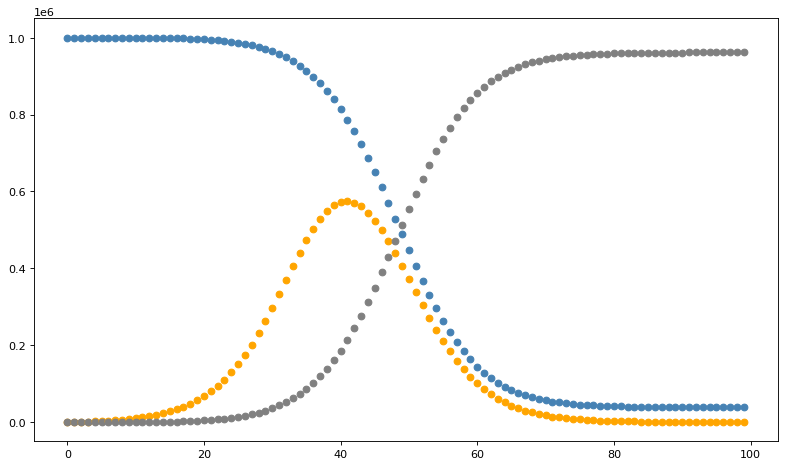

99 38297 86 961617


Text(3.5555555555555483, 0.5, 'Number of people')

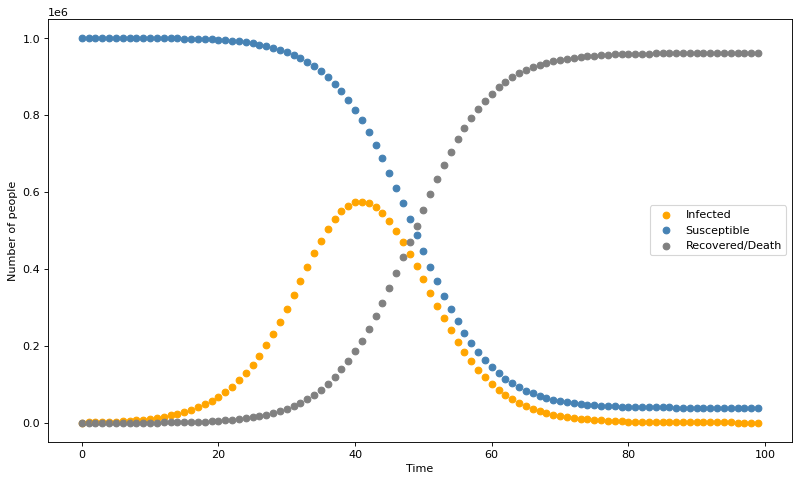

In [6]:
t = time.time()
df = data.copy()
df['t'] = None; df['r_time'] = None
result = pd.DataFrame()
fig=plt.figure(figsize=(12, 7), dpi= 80, facecolor='w', edgecolor='k')
list_susceptible = []
list_infected = []
list_removed = []    
for t in range(100):
    S = df.loc[df['status']=='S','status'].shape[0]
    I = df.loc[df['status']=='I','status'].shape[0]
    R = df.loc[df['status']=='R','status'].shape[0]
    
    pl.scatter(t, I, c='orange')
    pl.scatter(t, S+I, c='steelblue')
    pl.scatter(t, R, c='gray')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    
    print(t,S,I,R)
    # cross infection
    ind =  df.index[(df['status']=='S' )].tolist()
    if len(ind):
        df.loc[ind, ['status','t','r_time']] = [['I',t, min(24,x)] if rand.random() < INFECT_CHANCE*I*CONTACT/POP 
                                            else ['S',None,None] for x in np.random.poisson(15,len(ind))]
    
    # imported cases
    if t <= 15:
        fcase = np.random.binomial(S, FLIGHTS)
        findex = rand.sample(range(POP), fcase)
        findex = df.loc[(df.index.isin(findex))&(df['status']=='S')].index
        if len(findex):
            df.loc[findex, ['status','t','r_time']] = [['I',t, min(24,x)] for x in np.random.poisson(15,len(findex))]
    
    df.loc[df['r_time'] <= t - df['t'], 'status']='R'
    list_susceptible.append(S)
    list_infected.append(I)
    list_removed.append(R)
plt.legend(['Infected','Susceptible','Recovered/Death'])
plt.xlabel('Time')
plt.ylabel('Number of people')

In [7]:
print(list_susceptible)
print(list_infected)
print(list_removed)
print(len(list_infected))
list_total_case = []
# total case = infected + removed
for i in range(len(list_infected)):
  list_total_case.append(list_infected[i] + list_removed[i])
print(list_total_case)

[1000000, 999657, 999220, 998698, 998103, 997294, 996323, 995120, 993724, 992045, 989885, 987336, 984389, 980848, 976482, 971306, 965177, 958245, 949987, 940150, 928653, 915186, 899425, 881413, 860281, 836360, 809245, 778909, 745048, 707649, 667460, 624585, 579785, 533668, 487176, 440835, 395848, 352640, 312011, 274986, 241520, 211861, 185606, 162663, 142894, 126076, 111801, 99529, 89349, 80890, 73818, 67951, 63031, 58879, 55460, 52537, 50043, 48038, 46338, 44940, 43791, 42864, 42121, 41441, 40895, 40420, 40061, 39780, 39529, 39338, 39153, 39010, 38891, 38797, 38712, 38640, 38573, 38519, 38474, 38445, 38417, 38401, 38381, 38366, 38355, 38348, 38340, 38330, 38324, 38318, 38313, 38307, 38306, 38304, 38303, 38301, 38300, 38299, 38297, 38297]
[0, 343, 780, 1302, 1897, 2706, 3676, 4878, 6266, 7927, 10057, 12552, 15400, 18792, 22948, 27844, 33547, 39954, 47600, 56670, 67155, 79419, 93710, 109995, 128967, 150240, 174325, 200992, 230453, 262578, 296704, 332280, 368699, 404843, 439979, 473277, 

Streaming output truncated to the last 5000 lines.
Epoch 686/1000
2/2 - 0s - loss: 0.0030
Epoch 687/1000
2/2 - 0s - loss: 0.0030
Epoch 688/1000
2/2 - 0s - loss: 0.0030
Epoch 689/1000
2/2 - 0s - loss: 0.0031
Epoch 690/1000
2/2 - 0s - loss: 0.0030
Epoch 691/1000
2/2 - 0s - loss: 0.0030
Epoch 692/1000
2/2 - 0s - loss: 0.0030
Epoch 693/1000
2/2 - 0s - loss: 0.0030
Epoch 694/1000
2/2 - 0s - loss: 0.0030
Epoch 695/1000
2/2 - 0s - loss: 0.0030
Epoch 696/1000
2/2 - 0s - loss: 0.0030
Epoch 697/1000
2/2 - 0s - loss: 0.0030
Epoch 698/1000
2/2 - 0s - loss: 0.0030
Epoch 699/1000
2/2 - 0s - loss: 0.0032
Epoch 700/1000
2/2 - 0s - loss: 0.0030
Epoch 701/1000
2/2 - 0s - loss: 0.0031
Epoch 702/1000
2/2 - 0s - loss: 0.0031
Epoch 703/1000
2/2 - 0s - loss: 0.0030
Epoch 704/1000
2/2 - 0s - loss: 0.0030
Epoch 705/1000
2/2 - 0s - loss: 0.0030
Epoch 706/1000
2/2 - 0s - loss: 0.0030
Epoch 707/1000
2/2 - 0s - loss: 0.0029
Epoch 708/1000
2/2 - 0s - loss: 0.0030
Epoch 709/1000
2/2 - 0s - loss: 0.0030
Epoch 710/100

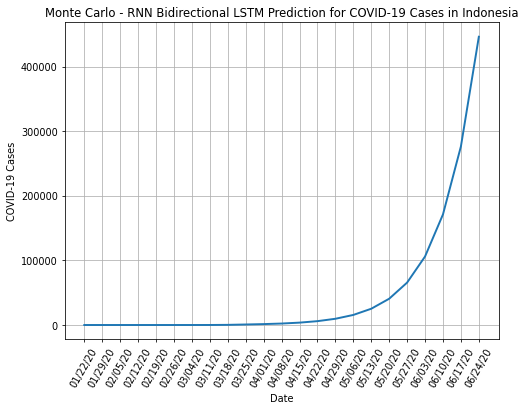

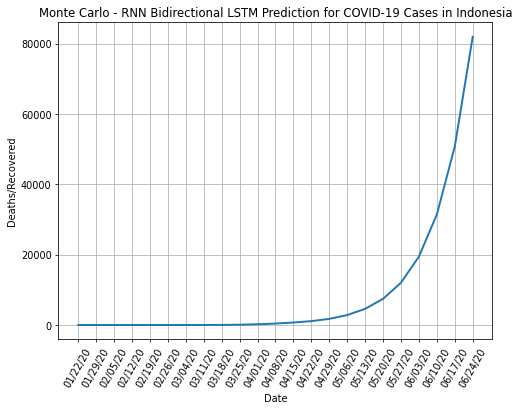

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
import requests
import datetime as date

#split a univariate (single parameter) sequence 
def split_sequence(seq,n_step,x_train,y_train): # seq: sequence of numbers ; n_step: number of elements to be sliced
  for i in range(len(seq)):
    end_elem = i + n_step #get index of end_elem -1 to be inserted to sliced list (index of final element = end_elem -1)
    if end_elem > len(seq)-1: #check if end_elem is out of bounds
      break
    #create 2 sliced lists => input and output
    sliced_x, sliced_y = seq[i:end_elem], seq[end_elem]
    x_train.append(sliced_x) 
    y_train.append(sliced_y)
  #print(x_train)
  return np.array(x_train), np.array(y_train)

def get_data(country):
  seq = []
  resp = requests.get("https://corona.lmao.ninja/v2/historical/"+ country) #GET HTTP response
  json_result = resp.json() #get json only
  inner_dict = json_result['timeline']['cases'] #get total cases only
  #create list of total cases in a sequential time series
  for k,v in inner_dict.items():
    seq.append(v)
  return seq

def get_data_train(country):
  seq = []
  resp = requests.get("https://corona.lmao.ninja/v2/historical/"+ country) #GET HTTP response
  json_result = resp.json() #get json only
  inner_dict = json_result['timeline']['cases'] #get total cases only
  #create list of total cases in a sequential time series
  for k,v in inner_dict.items():
    if (v != 0):
      seq.append(v)
  return seq

# get deaths + recovered data
def get_removed_train(country):
  resp = requests.get("https://pomber.github.io/covid19/timeseries.json")
  data = resp.json()
  removed_data = []
  country_data = data[country]
  for i in range(len(country_data)):
    removed_data.append(country_data[i]['deaths'] + country_data[i]['recovered'])
  return removed_data

time_series = get_data_train("japan")
time_series_test = get_data("indonesia")
removed_train = get_removed_train("Italy")
removed_test = get_removed_train("Indonesia")

#print(time_series)
#choose number of time steps (length of sliced list)
n_step = 3
#split input sequential time series into samples of sliced lists
x_train, y_train =[],[]
x_train, y_train = split_sequence(time_series, n_step,x_train,y_train) #Japan data
x_mc_train, y_mc_train = [],[]
x_mc_train, y_mc_train = split_sequence(list_total_case, n_step, x_mc_train,y_mc_train) #Monte Carlo Data
# reshape from [samples, timesteps] -> [samples, timesteps, features]
n_feature = 1
#print(x_train.shape)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],n_feature))
x_mc_train = x_mc_train.reshape((x_mc_train.shape[0],x_mc_train.shape[1],n_feature))
#print(x_train)

#prepared removed(deaths + recovered) data
xr_train, yr_train =[],[]
xr_train, yr_train = split_sequence(removed_train, n_step, xr_train, yr_train) #Italy data
xr_mc_train, yr_mc_train =[],[]
xr_mc_train, yr_mc_train = split_sequence(list_removed, n_step, xr_mc_train, yr_mc_train) #Monte Carlo Data
xr_train = xr_train.reshape((xr_train.shape[0],xr_train.shape[1],n_feature))
xr_mc_train = xr_mc_train.reshape((xr_mc_train.shape[0],xr_mc_train.shape[1],n_feature))

#define bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(256, activation='relu'), input_shape=(n_step,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

model2 = Sequential()
model2.add(Bidirectional(LSTM(256, activation ='relu'),input_shape=(n_step,n_feature)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

#number of epochs / training
model.fit(x_mc_train,y_mc_train, epochs =1000, verbose=2) #Train from monte carlo  
model.fit(x_train, y_train, epochs = 1000, verbose=2)
print(time_series)
print(time_series_test)

model2.fit(xr_mc_train,yr_mc_train, epochs =1000, verbose=2) #Train from monte carlo  
model2.fit(xr_train, yr_train, epochs = 1000, verbose=2)
#evaluate model
model.evaluate(x_train,y_train,verbose=2)
model2.evaluate(xr_train, yr_train, verbose=2)

#run prediction using Indo data
x_test_list = time_series_test[-4:len(time_series_test)-1] #get last 3 elements from time_series list
time_series_pred = time_series_test[:len(time_series_test)-1]
x_test = np.array(x_test_list)

xr_test_list = removed_test[-4:len(removed_test)-1]
xr_pred = removed_test[:len(removed_test)-1]
xr_test = np.array(xr_test_list)

for i in range(90):
  x_test = x_test.reshape((1, n_step, n_feature))
  xr_test = xr_test.reshape((1, n_step, n_feature))
  y_test = model.predict(x_test, verbose=2)
  y_test_rounded = round(y_test[0][0])
  yr_test = model.predict(xr_test, verbose=2)
  yr_test_rounded = round(yr_test[0][0])
  print(y_test_rounded)
  print(yr_test_rounded)
  time_series_pred.append(y_test_rounded)
  xr_pred.append(yr_test_rounded)
  x_test = np.append(x_test,y_test) #append test result to last element from list
  x_test = np.delete(x_test,0) #delete first element from list
  xr_test = np.append(xr_test, yr_test)
  xr_test = np.delete(xr_test,0)

  day = date.datetime(2020,1,22) #day one of infection
day_formatted = day.strftime("%m/%d/%y") #format date

days = []
days.append(day_formatted)
time_series_weekly_pred=[]
removed_weekly_pred = []
#generate days
for i in range(1,len(time_series_pred)):
  day += date.timedelta(days=1)
  day_formatted = day.strftime("%m/%d/%y")
  if ((i % 7) ==0):
    days.append(day_formatted)
print(days)

#create weekly time series pred
for i in range(len(time_series_pred)):
  if ((i%7) == 0):
    time_series_weekly_pred.append(int(time_series_pred[i]))
print(time_series_pred)
print(time_series_weekly_pred)

for i in range(len(xr_pred)):
  if ((i%7) == 0):
    removed_weekly_pred.append(int(xr_pred[i]))
print(xr_pred)
print(removed_weekly_pred)

plt.figure(figsize=(8,6),dpi=70)
plt.ticklabel_format(style='plain')
plt.plot(days,time_series_weekly_pred,linewidth=2)# set x-axis as days and y-axis as number of cases 
plt.xticks(rotation=60) #rotate x-axis label
#name axes
plt.xlabel('Date')
plt.ylabel('COVID-19 Cases')
#name title of graph
plt.title('Monte Carlo - RNN Bidirectional LSTM Prediction for COVID-19 Cases in Indonesia')
plt.grid()
plt.yscale("linear")
plt.show()

plt.figure(figsize=(8,6),dpi=70)
plt.ticklabel_format(style='plain')
plt.plot(days,removed_weekly_pred,linewidth=2)# set x-axis as days and y-axis as number of cases 
plt.xticks(rotation=60) #rotate x-axis label
#name axes
plt.xlabel('Date')
plt.ylabel('Deaths/Recovered')
#name title of graph
plt.title('Monte Carlo - RNN Bidirectional LSTM Prediction for COVID-19 Cases in Indonesia')
plt.grid()
plt.yscale("linear")
plt.show()